In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P14NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 31772 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'P28_Type'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 6247 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'P28_Type'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

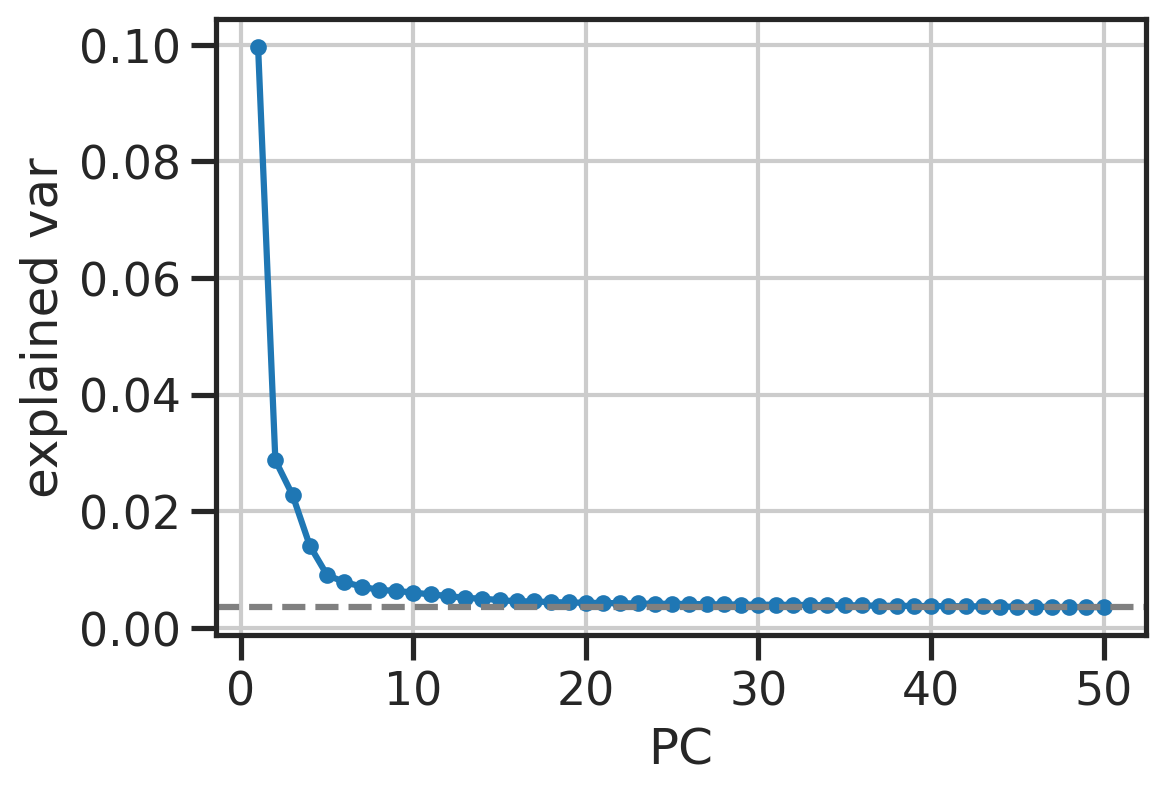

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

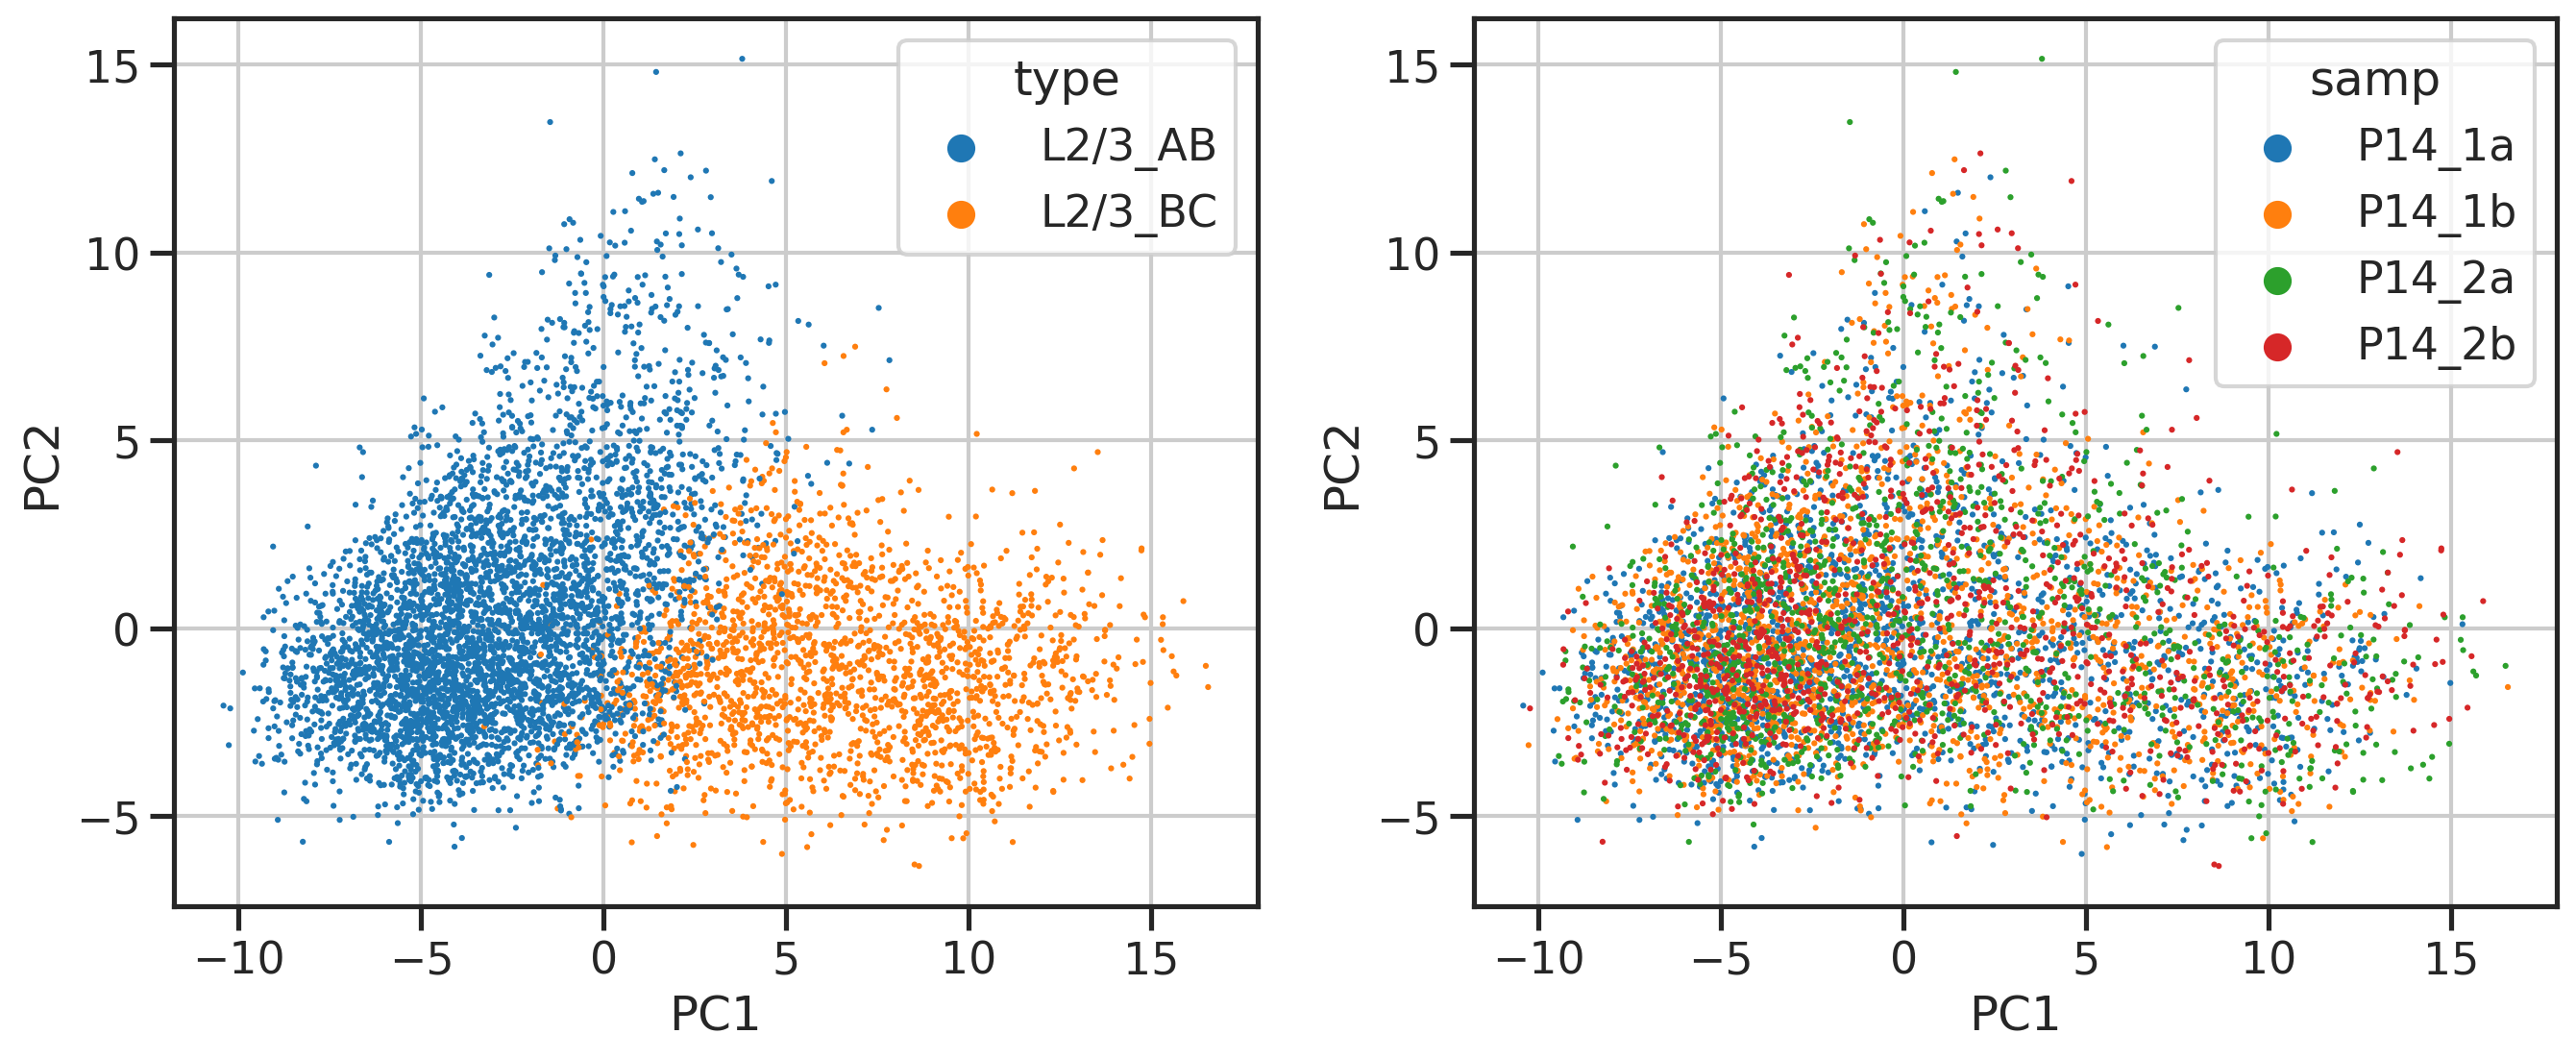

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

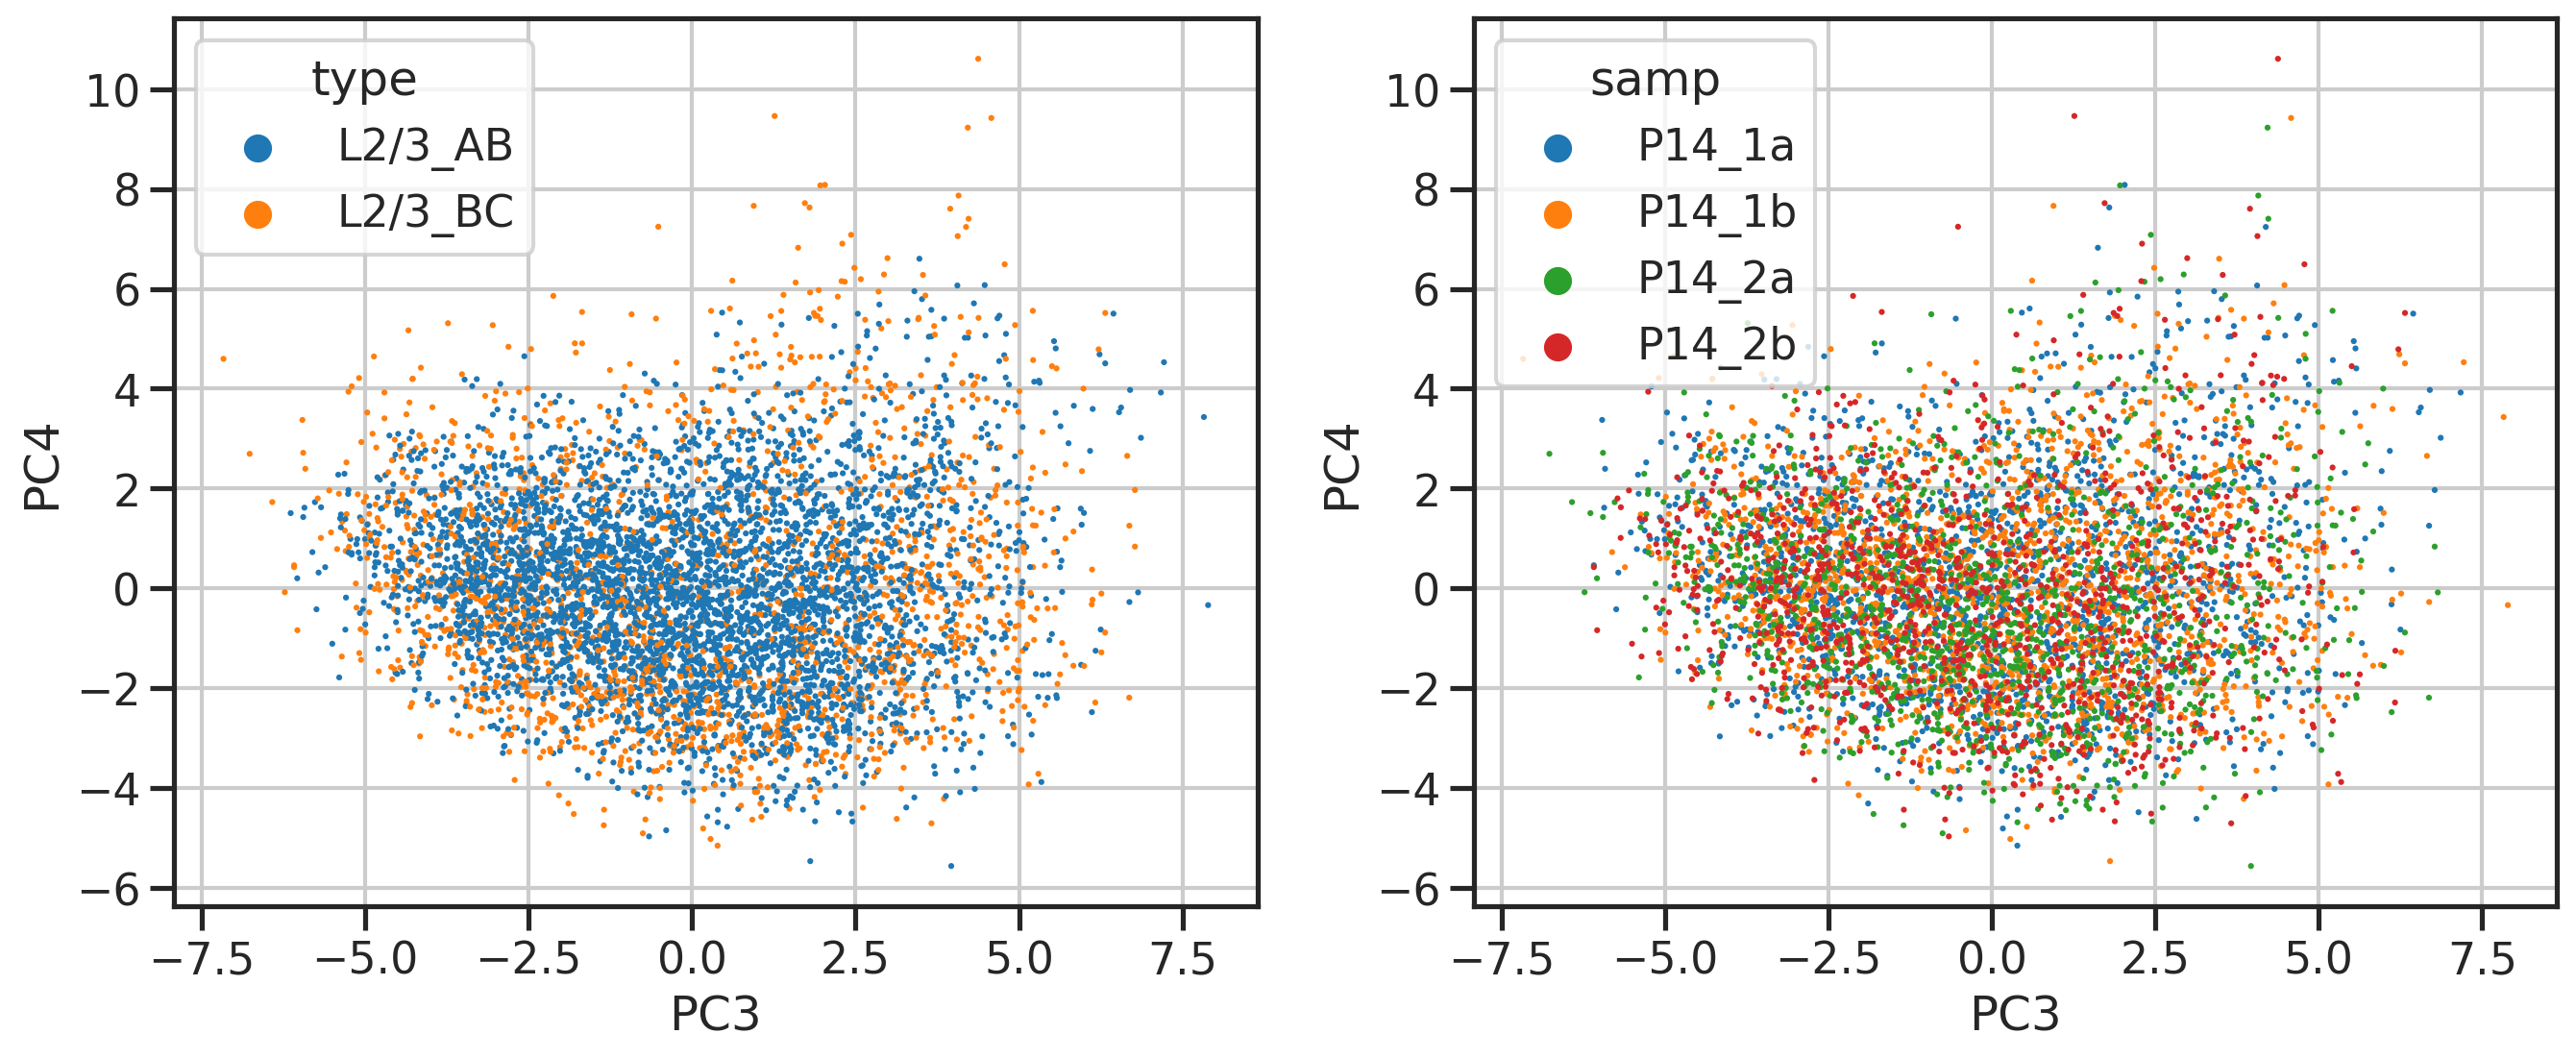

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

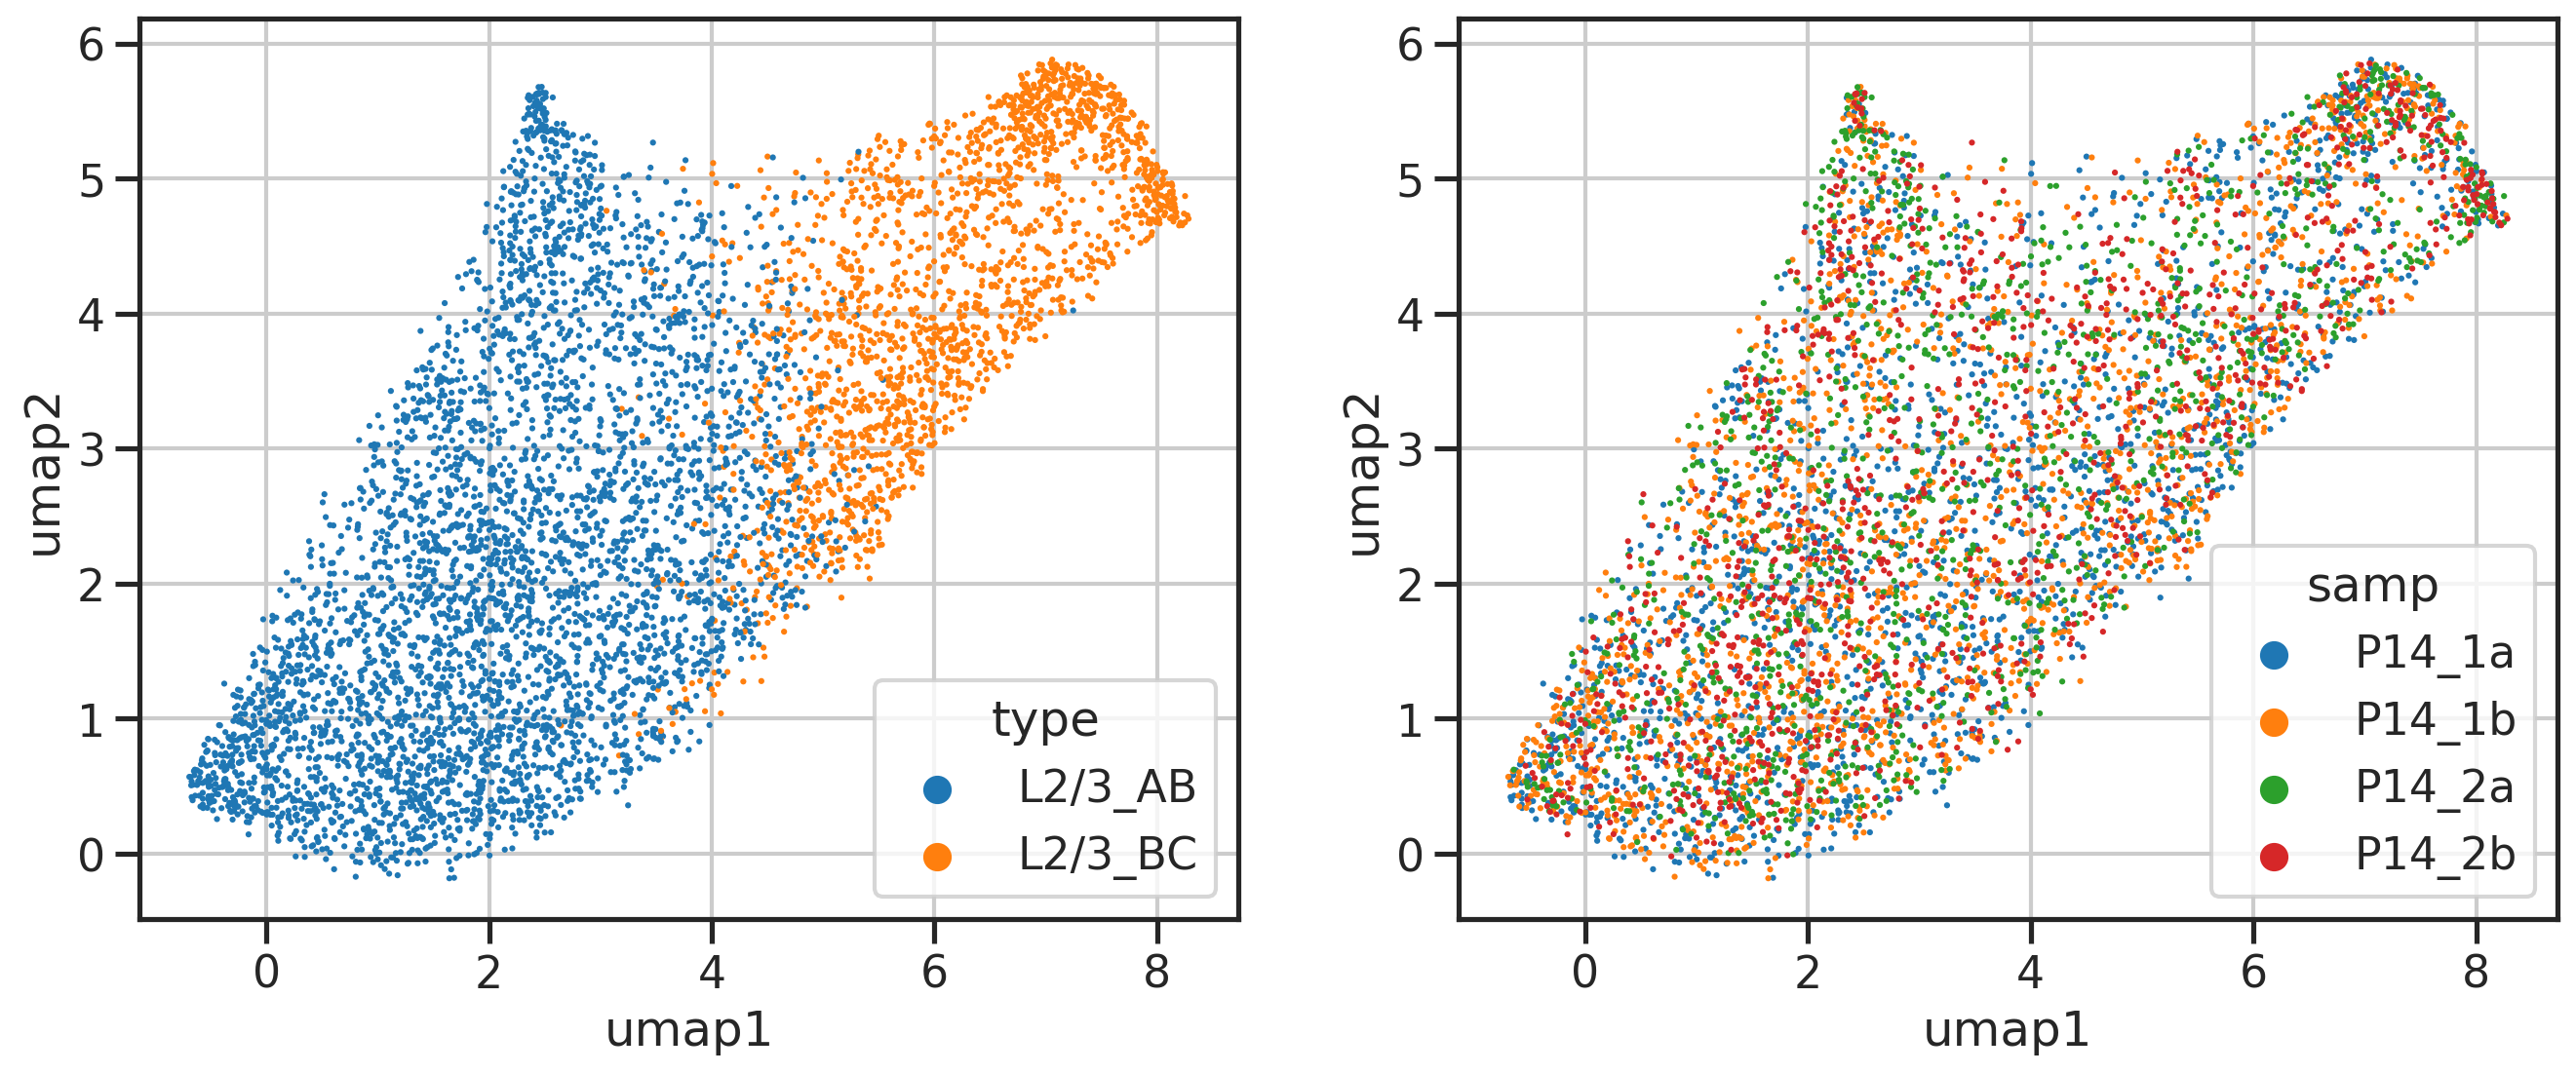

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

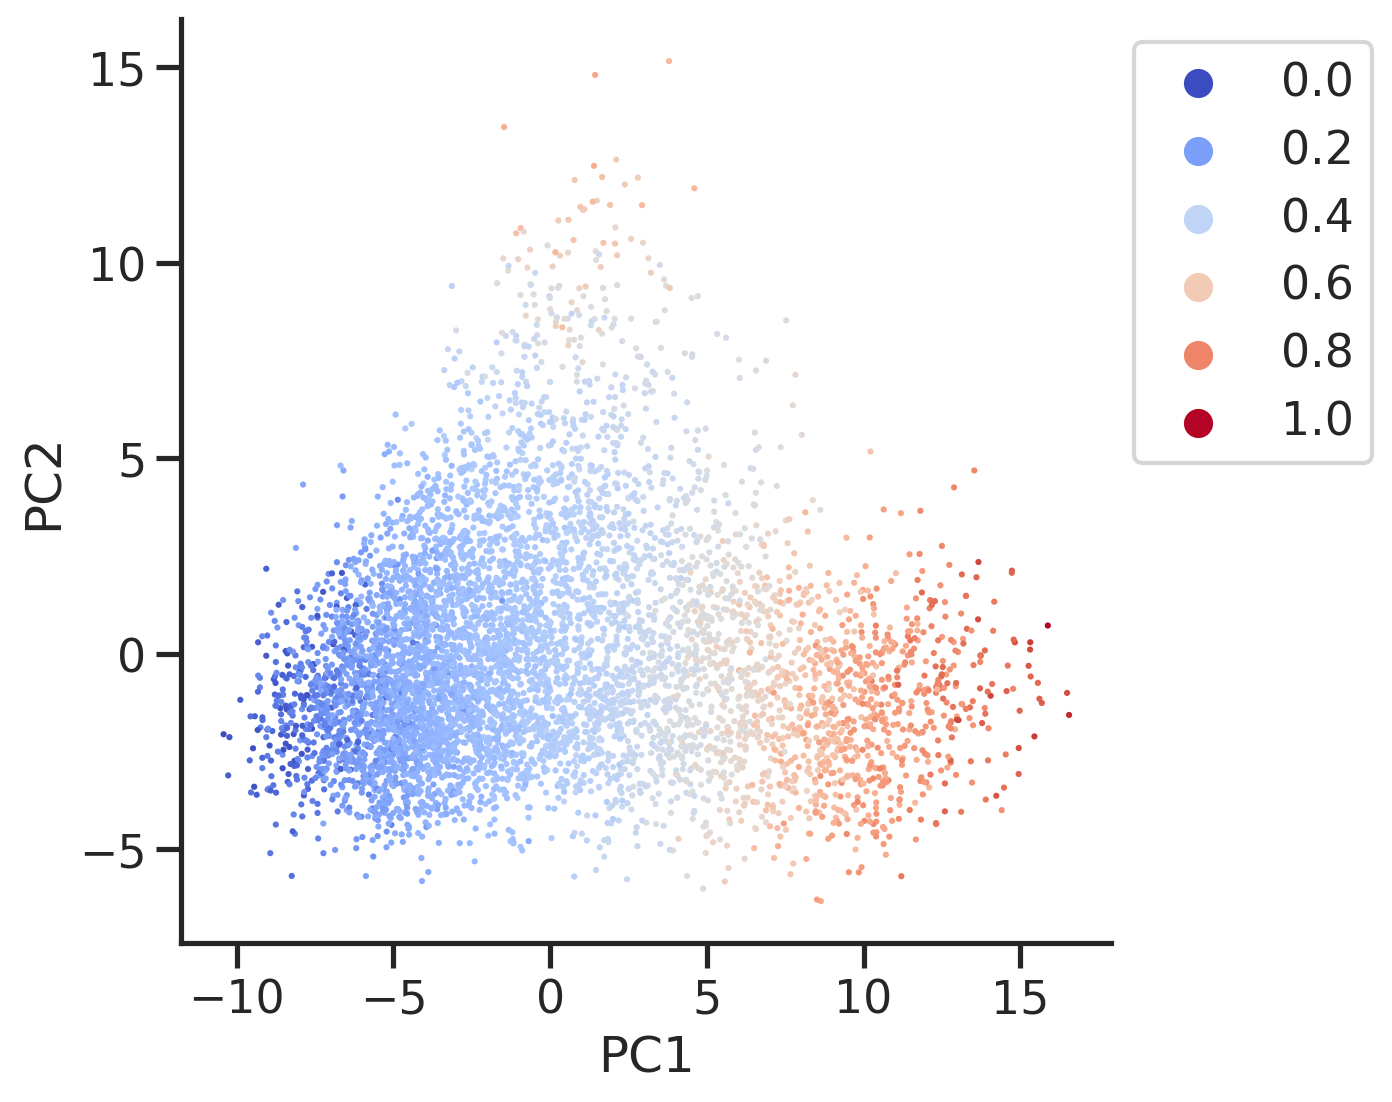

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:04:38 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


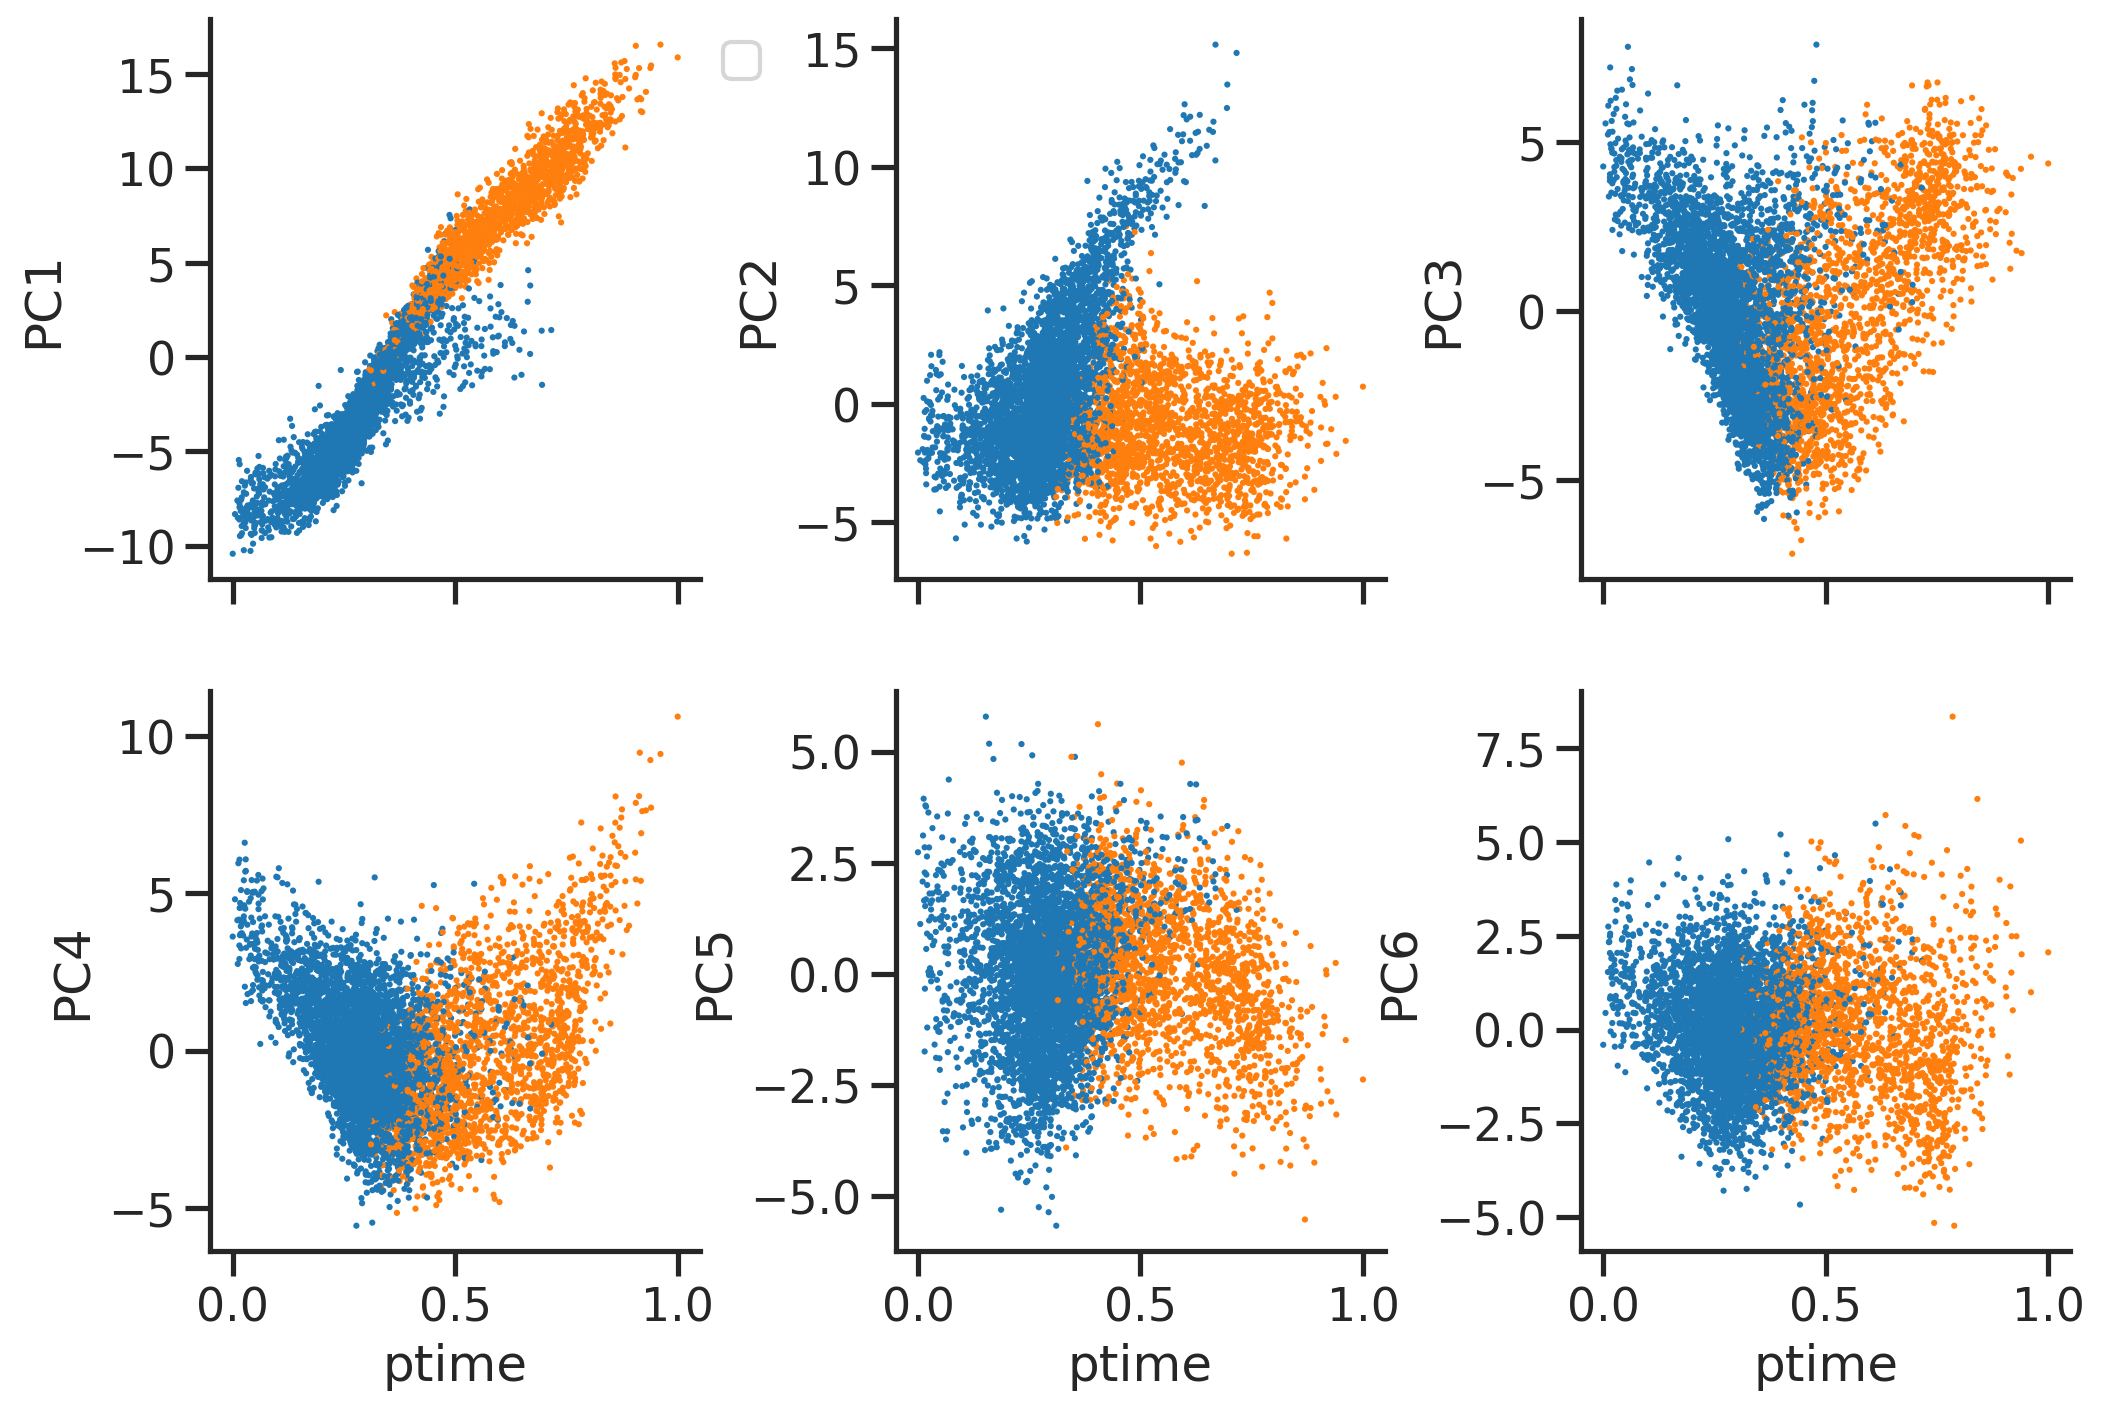

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:04:46 - maxp pruned
03-28 14:04:46 - cmap pruned
03-28 14:04:46 - kern dropped
03-28 14:04:46 - post pruned
03-28 14:04:46 - FFTM dropped
03-28 14:04:46 - GPOS pruned
03-28 14:04:46 - GSUB pruned
03-28 14:04:46 - name pruned
03-28 14:04:46 - glyf pruned
03-28 14:04:46 - Added gid0 to subset
03-28 14:04:46 - Added first four glyphs to subset
03-28 14:04:46 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:04:46 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:04:46 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:04:46 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:04:46 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P14NR_v4_2023-03-28.pdf


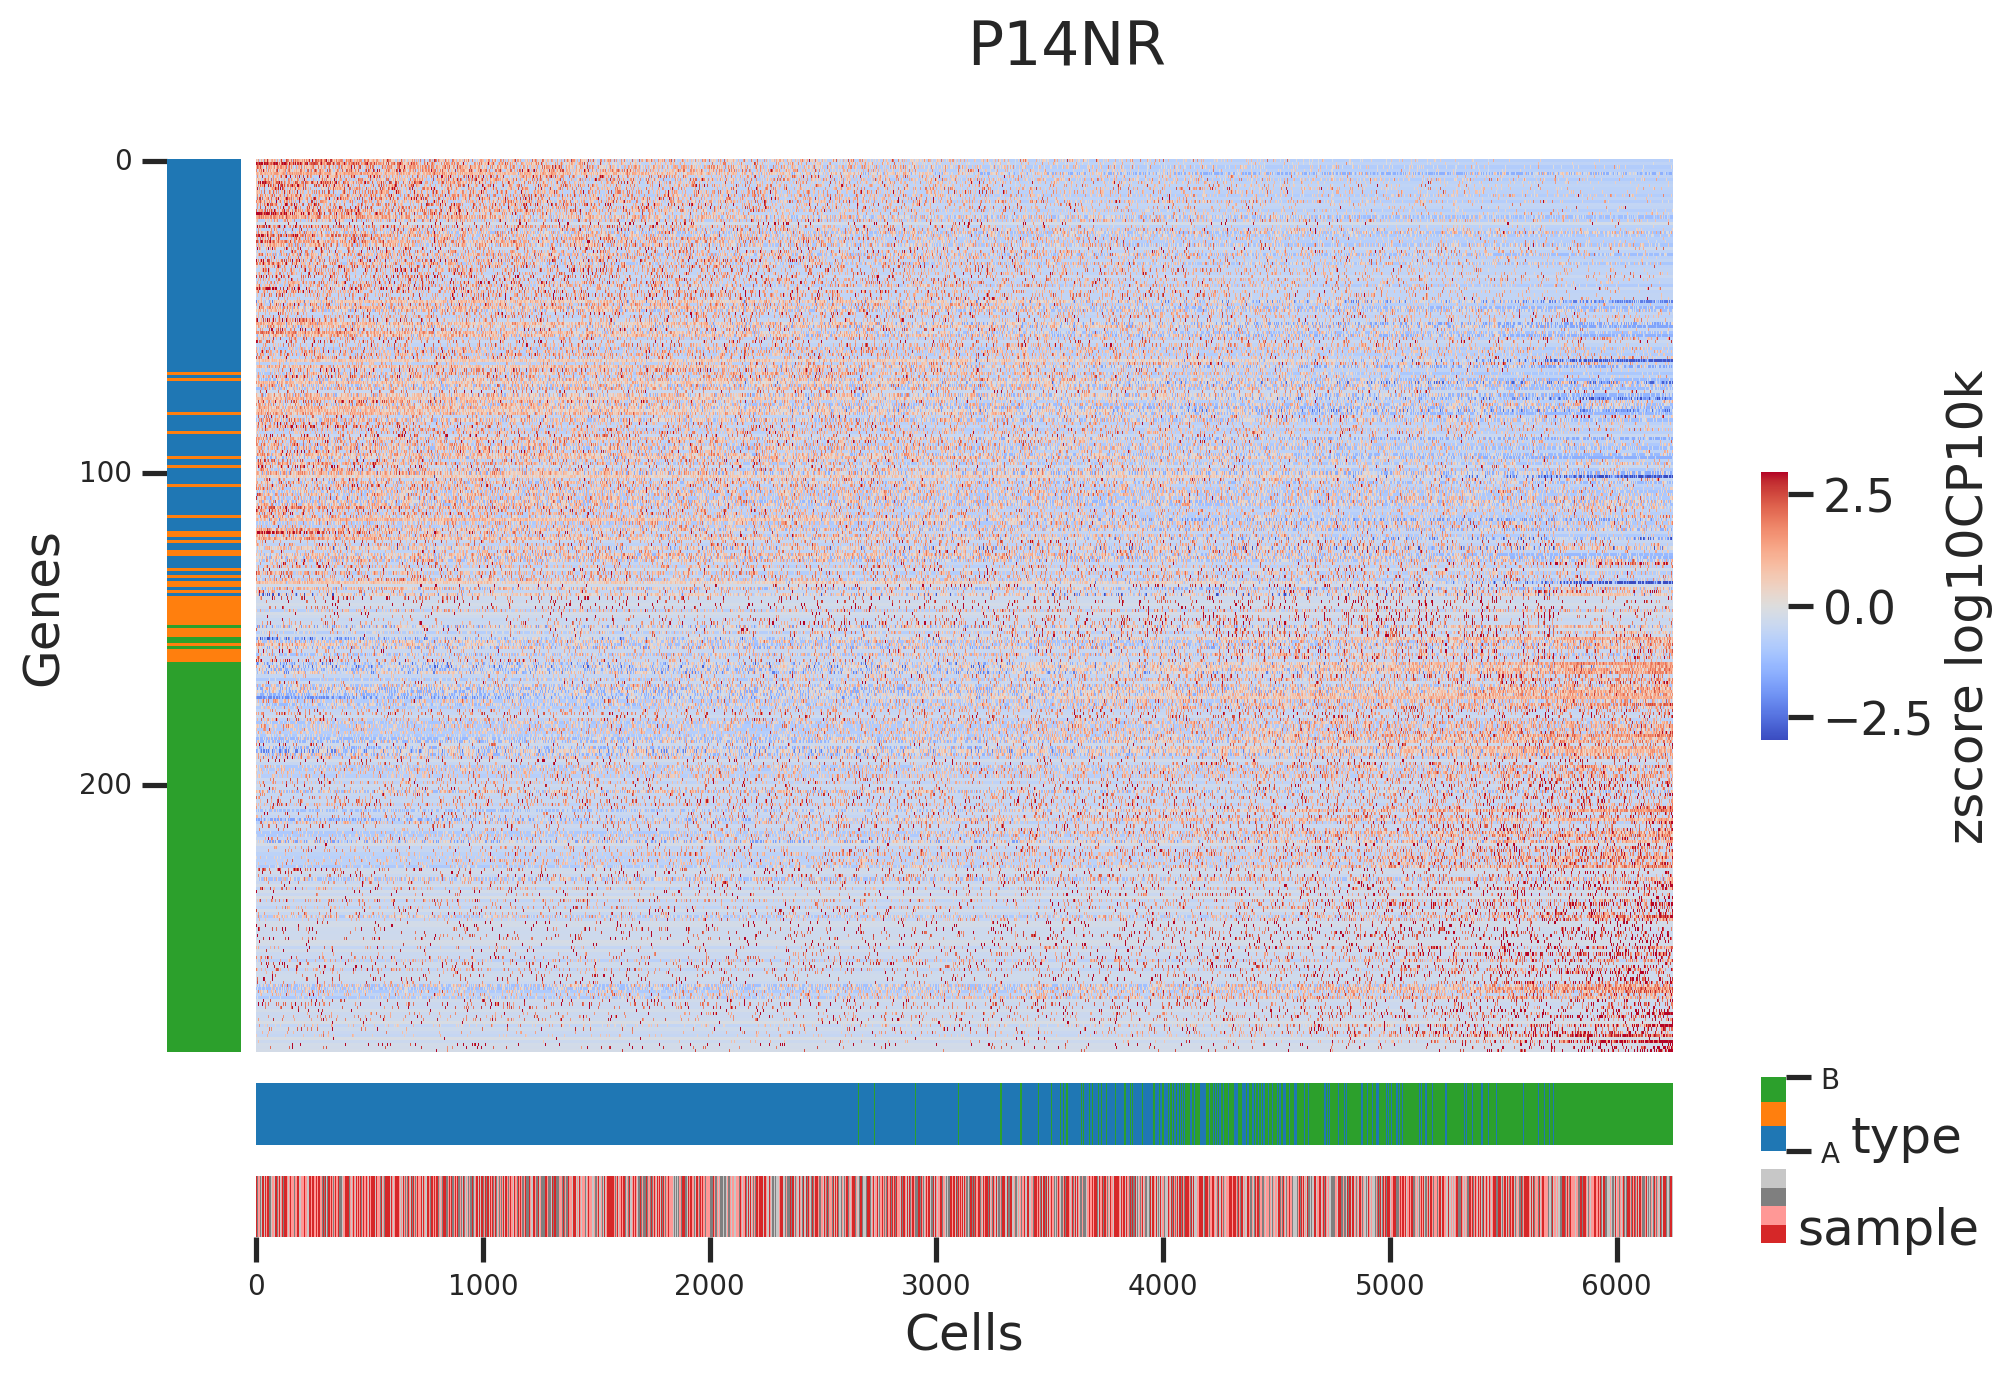

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCATCCGTATAG-1-P14_1a-P14 -4.190401  2.351460  2.425667  0.698668   
AAACCCATCTTCGACC-1-P14_1a-P14 -4.999456 -3.380683  0.738911 -0.801240   
AAACGAACATGTTTGG-1-P14_1a-P14  4.482727 -0.013880 -3.513310  0.011792   
AAACGCTCAAAGGCTG-1-P14_1a-P14 -3.782699 -3.957378 -0.421789  0.275932   
AAACGCTCAATCTAGC-1-P14_1a-P14  5.643119  2.303261 -0.784905 -0.704538   
...                                 ...       ...       ...       ...   
TTTGATCCATAATGAG-1-P14_2b-P14 -7.298696 -1.294293  2.956571  1.275952   
TTTGGTTGTACTCCCT-1-P14_2b-P14  4.800097  0.777477  1.156887 -3.983781   
TTTGTTGAGGTCATCT-1-P14_2b-P14 -5.197329 -0.352891 -0.045212  0.695571   
TTTGTTGGTCGCAACC-1-P14_2b-P14 -1.208256  4.580493  1.680765 -0.986183   
TTTGTTGTCTGTCCCA-1-P14_2b-P14  6.057204 -2.323504  2.207473 -2.546000   

                                    PC5       PC6       PC7       PC8  \
AAACCCATCCGTATAG-1-P14_1a-P14  0.826410 -0.596451 -0.700826  1.633410   
AAACCCATCTTCGACC-1-P14_1a-P14  2.070321  0.728994  1.562537  0.329016   
AAACGAACATGTTTGG-1-P14_1a-P14  3.065735  1.268733 -1.132523 -1.587622   
AAACGCTCAAAGGCTG-1-P14_1a-P14 -0.346164  1.218006  0.409325  1.160717   
AAACGCTCAATCTAGC-1-P14_1a-P14  0.486066 -0.387062 -0.648689 -1.697284   
...                                 ...       ...       ...       ...   
TTTGATCCATAATGAG-1-P14_2b-P14  0.049716  0.310274  0.470662 -1.080359   
TTTGGTTGTACTCCCT-1-P14_2b-P14 -1.159170  0.095921 -0.246872 -0.432997   
TTTGTTGAGGTCATCT-1-P14_2b-P14 -0.055304 -1.728003  0.118433 -0.951338   
TTTGTTGGTCGCAACC-1-P14_2b-P14  2.200484  1.533767  0.439224 -0.008273   
TTTGTTGTCTGTCCCA-1-P14_2b-P14 -0.832975 -1.222490 -0.135276 -0.604837   

                                    PC9      PC10  ...      PC46      PC47  \
AAACCCATCCGTATAG-1-P14_1a-P14  2.151714 -0.775861  ...  0.895371 -2.407516   
AAACCCATCTTCGACC-1-P14_1a-P14 -0.116317 -0.715295  ...  0.549418  0.058838   
AAACGAACATGTTTGG-1-P14_1a-P14 -1.719840 -0.148356  ... -0.560618 -1.223754   
AAACGCTCAAAGGCTG-1-P14_1a-P14  1.545645  0.135941  ... -0.143182  2.741449   
AAACGCTCAATCTAGC-1-P14_1a-P14 -0.701012 -0.137202  ...  0.041139 -0.061118   
...                                 ...       ...  ...       ...       ...   
TTTGATCCATAATGAG-1-P14_2b-P14  0.024949 -0.672933  ...  0.740849 -3.104917   
TTTGGTTGTACTCCCT-1-P14_2b-P14 -1.044639  1.020143  ...  0.454135  0.709269   
TTTGTTGAGGTCATCT-1-P14_2b-P14  0.162469  1.615211  ...  0.519339 -0.358255   
TTTGTTGGTCGCAACC-1-P14_2b-P14  0.887425  0.902236  ... -0.453400  1.080452   
TTTGTTGTCTGTCCCA-1-P14_2b-P14 -1.493159 -0.872745  ... -0.641383  1.975121   

                                   PC48      PC49      PC50     type    samp  \
AAACCCATCCGTATAG-1-P14_1a-P14 -0.448135 -1.395162  1.938469  L2/3_AB  P14_1a   
AAACCCATCTTCGACC-1-P14_1a-P14 -1.908239  0.926431 -0.517705  L2/3_AB  P14_1a   
AAACGAACATGTTTGG-1-P14_1a-P14 -0.488035  1.380202  0.031953  L2/3_BC  P14_1a   
AAACGCTCAAAGGCTG-1-P14_1a-P14 -0.064271  0.687261  0.763902  L2/3_AB  P14_1a   
AAACGCTCAATCTAGC-1-P14_1a-P14  0.409855 -0.701568 -1.302068  L2/3_BC  P14_1a   
...                                 ...       ...       ...      ...     ...   
TTTGATCCATAATGAG-1-P14_2b-P14  1.232133  0.496219 -0.772483  L2/3_AB  P14_2b   
TTTGGTTGTACTCCCT-1-P14_2b-P14  0.184393 -1.186718  0.720313  L2/3_BC  P14_2b   
TTTGTTGAGGTCATCT-1-P14_2b-P14  1.646785 -0.424999 -0.517746  L2/3_AB  P14_2b   
TTTGTTGGTCGCAACC-1-P14_2b-P14 -0.045162 -0.384685 -0.092533  L2/3_AB  P14_2b   
TTTGTTGTCTGTCCCA-1-P14_2b-P14  1.245450  1.413305  0.318637  L2/3_BC  P14_2b   

                                  umap1     umap2     ptime  
AAACCCATCCGTATAG-1-P14_1a-P14  1.214285  2.772294  0.262535  
AAACCCATCTTCGACC-1-P14_1a-P14  1.637563  0.030934  0.244065  
AAACGAACATGTTTGG-1-P14_1a-P14  5.681490  3.395064  0.489799  
AAACGCTCAAAGGCTG-1-P14_1a-P14  2.380868  0.390976  0.263775  
AAACGCTCAATCTAGC-1-P14_1a-P14  5.142112  4.367198  0.496633  
...         

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)